In [2]:
import torch
torch.set_default_dtype(torch.float64)
import tntorch as tn
import matplotlib.pyplot as plt
import numpy as np

## tntorch: tensor decomposition

In [3]:
randT = np.random.randint(0, 100, size=(128, 128, 128))

#conver to tensor 
fullT = torch.Tensor(randT)
fullT.shape

torch.Size([128, 128, 128])

In [4]:
def describe(decomposed, fullT):
    print(decomposed)
    print('Original tensor elements:',fullT.numel())
    print('Decomposed tensor elements:',decomposed.numcoef())
    print('Compression ratio: {}/{} = {:g}'.format(fullT.numel(), decomposed.numcoef(), fullT.numel() / decomposed.numcoef()))
    print('Relative error:', tn.relative_error(fullT, decomposed))
    print('RMSE:', tn.rmse(fullT, decomposed))
    print('R^2:', tn.r_squared(fullT, decomposed))

### TTD 

In [5]:
#decompose
ttdT = tn.Tensor(fullT, ranks_tt=3)
describe(ttdT,fullT)

3D TT tensor:

 128 128 128
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   3   3   1

Original tensor elements: 2097152
Decomposed tensor elements: 1920
Compression ratio: 2097152/1920 = 1092.27
Relative error: tensor(0.5039)
RMSE: tensor(28.8620)
R^2: tensor(0.0013)


## CPD

In [6]:
cpdT = tn.Tensor(fullT, ranks_cp=6, verbose=True)
describe(cpdT, fullT)

ALS -- initialization time = 0.07799959182739258
iter: 0  | eps: 0.50389461 | total time:    0.1530
iter: 1  | eps: 0.50378534 | total time:    0.2180
iter: 2  | eps: 0.50373994 | total time:    0.2970 <- converged (tol=0.0001)
3D CP tensor:

 128 128 128
  |   |   |
 <0> <1> <2>
 / \ / \ / \
6   6   6   6

Original tensor elements: 2097152
Decomposed tensor elements: 2304
Compression ratio: 2097152/2304 = 910.222
Relative error: tensor(0.5037)
RMSE: tensor(28.8532)
R^2: tensor(0.0019)


In [7]:
#test norms
orig = torch.rand(10,15,20)

cpdT = tn.Tensor(orig, ranks_cp=10)
test1 = cpdT.torch()

ttdT = tn.Tensor(orig, ranks_tt=10)
test2 = ttdT.torch()

print(torch.norm(orig))
print(torch.norm(test1))
print(torch.norm(test2))

tensor(32.0787)
tensor(29.0305)
tensor(30.6270)


## Compressing & decompressing an image using TTD

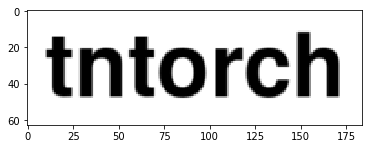

2D TT tensor:

 63  184
  |   |
 (0) (1)
 / \ / \
1   10  1

iter: 0       | loss: 197.937746 | total time:    0.0095
iter: 500     | loss:  29.722131 | total time:    1.7274
iter: 1000    | loss:  19.231694 | total time:    2.9394
iter: 1500    | loss:   8.330698 | total time:    4.0369
iter: 2000    | loss:   4.351355 | total time:    5.1291
iter: 2500    | loss:   2.933643 | total time:    6.3137
iter: 2788    | loss:   2.693346 | total time:    7.0017 <- converged (tol=0.0001)


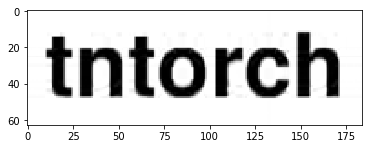

In [8]:
im = torch.DoubleTensor(plt.imread('tntorch/images/text.png'))
plt.imshow(im.numpy(), cmap='gray')
plt.show()

#TTD
t = tn.rand(im.shape, ranks_tt=10, requires_grad=True)
print(t)

def loss(t):
    return tn.dist(t, im)  # Equivalent to torch.norm(t.torch() - im)

tn.optimize(t, loss)

# restore image from ttd representation
final_img = t.numpy()
plt.imshow(final_img, cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

## Tensor completion

In [9]:
P = im.shape[0]*im.shape[1]
Q = int(P/4)
print('We will keep {} out of {} pixels'.format(Q, P))
X = np.unravel_index(np.random.choice(P, Q), im.shape)  # Coordinates of surviving pixels
y = torch.Tensor(im[X])  # Grayscale values of surviving pixels

We will keep 2898 out of 11592 pixels


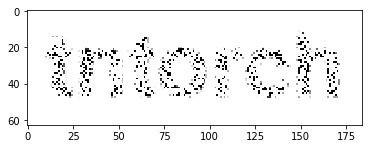

In [10]:
mask = np.ones([im.shape[0], im.shape[1]])
mask[X] = y
plt.imshow(mask, cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

iter: 0       | loss:   1.045079 | total time:    0.0080
iter: 500     | loss:   0.242116 | total time:    2.8311
iter: 1000    | loss:   0.152270 | total time:    4.8077
iter: 1500    | loss:   0.082828 | total time:    6.5693
iter: 2000    | loss:   0.055558 | total time:    8.2923
iter: 2500    | loss:   0.043802 | total time:   10.0202
iter: 3000    | loss:   0.034887 | total time:   11.7313
iter: 3500    | loss:   0.028529 | total time:   13.4816
iter: 4000    | loss:   0.024333 | total time:   16.4528
iter: 4500    | loss:   0.022477 | total time:   18.9972
iter: 5000    | loss:   0.020905 | total time:   21.4952
iter: 5500    | loss:   0.018828 | total time:   23.9437
iter: 5666    | loss:   0.018454 | total time:   24.6314 <- converged (tol=0.0001)


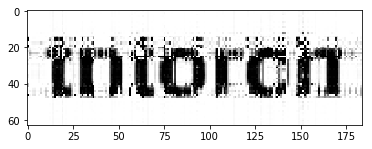

In [11]:
t = tn.rand(im.shape, ranks_tt=6, requires_grad=True)

def loss(t):
    return tn.relative_error(y, t[X])
tn.optimize(t, loss)

plt.imshow(t.numpy(), cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()